# 1. Import libraries and loading data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
pd.set_option("display.max.rows",None)
pd.set_option("display.max.columns",None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='pastel')

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline

from sklearn.utils.extmath import softmax

In [4]:
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

## 1.1. Data description

In [5]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


### Feature descriptions:

* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Checking missig values

In [7]:
print('Train:')
print(train.isna().sum())

print('\nTest:')
print(test.isna().sum())

Train:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Cheching duplicates

In [8]:
print(f'Train: {train.duplicated().sum()} \nTest: {test.duplicated().sum()}')

Train: 0 
Test: 0


# 2. Exploratory Data Analysis

## 2.1. Target distribution

Text(0.5, 1.0, 'Target distribution')

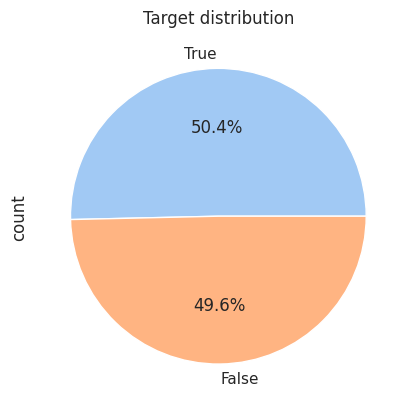

In [9]:
train['Transported'].value_counts().plot.pie(autopct='%1.1f%%').set_title("Target distribution")

## 2.2. Category distribution

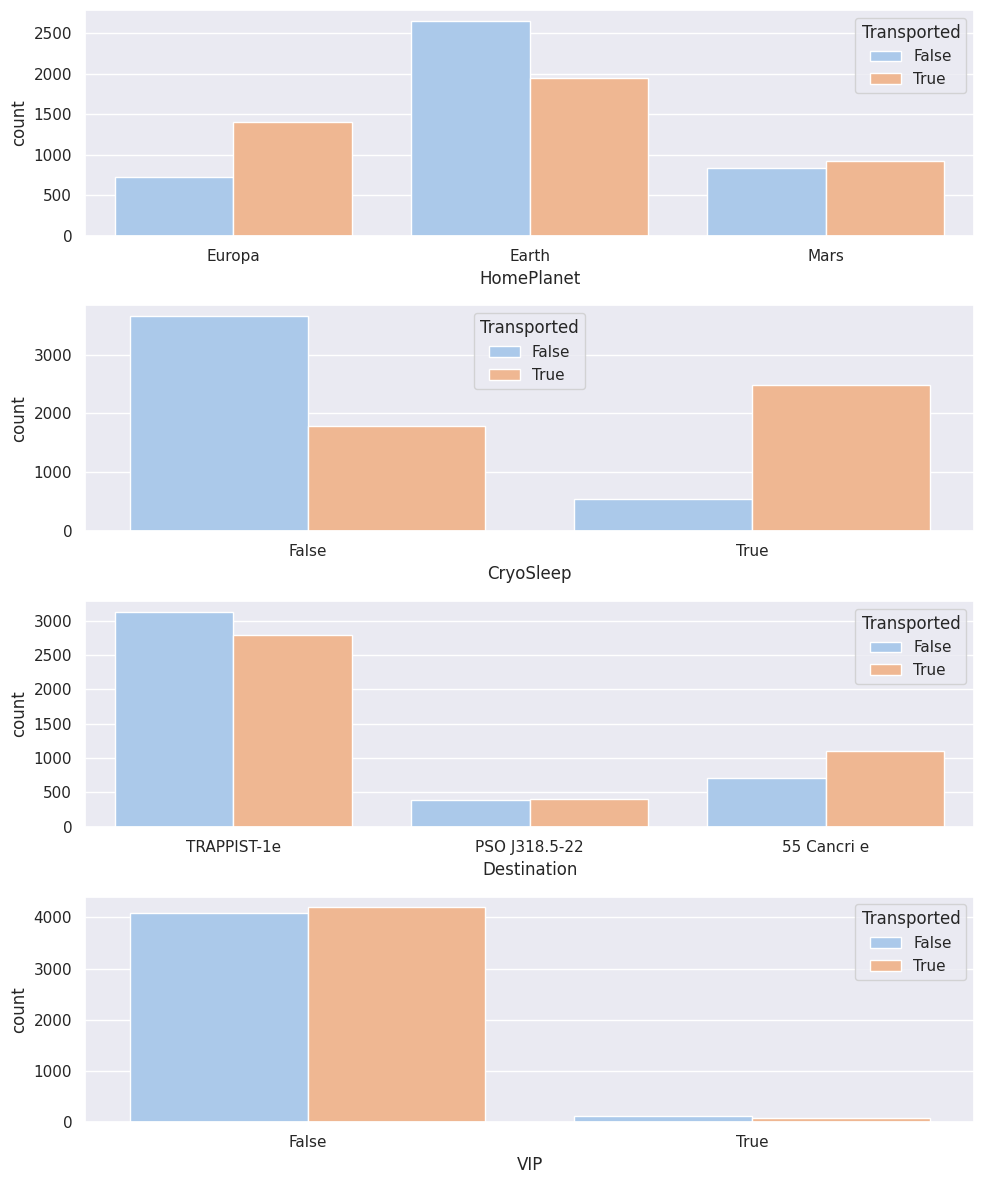

In [10]:
fig=plt.figure(figsize=(10,12))
for i, name in enumerate(['HomePlanet', 'CryoSleep', 'Destination', 'VIP']):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(x=name, hue='Transported', data=train)
fig.tight_layout()
plt.show()

### Notes
* People in cryosleep had a **higher** chance of being transported.
* VIP status didn't affect on transportation.

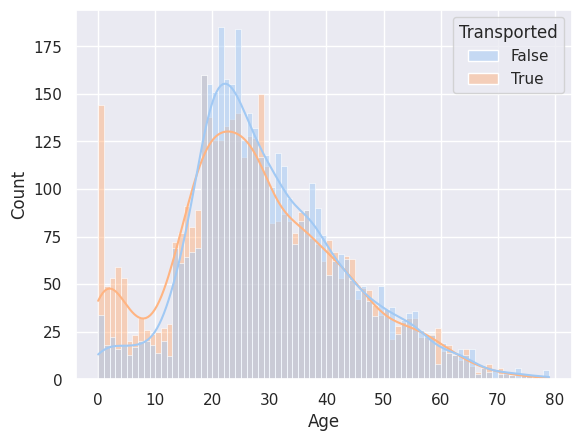

In [11]:
sns.histplot(x=train['Age'] ,hue='Transported', data=train, binwidth=1, kde=True);

### Notes
* Children under the age of 18 had the **highest** likelihood of being transported.
* In contrast, young adults aged 18 to 25 had the **lowest** likelihood of transportation.
* Adults aged 25 and above had approximately **equal** chances of being transported.

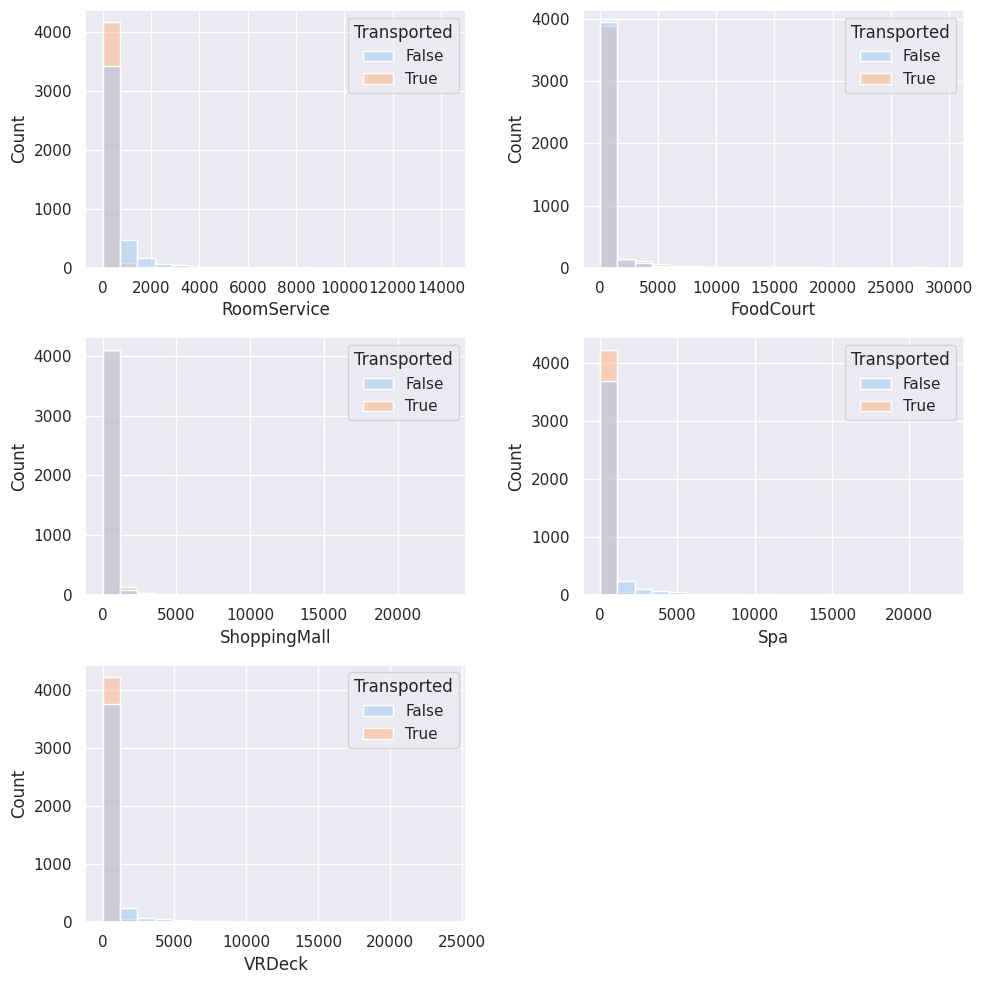

In [12]:
fig=plt.figure(figsize=(10,10))
for i, name in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    ax=fig.add_subplot(3, 2, i+1)
    sns.histplot(data=train, x=name, hue='Transported', axes=ax, bins=20)
fig.tight_layout()
plt.show()

### Notes
* The majority of people did not spend money on additional amenities, yet they had a **higher** likelihood of being transported (Room Service, Spa, VR Deck)

# 3. Feature Engineering

## 3.1. Age groups


<Axes: xlabel='AgeGroup', ylabel='Transported'>

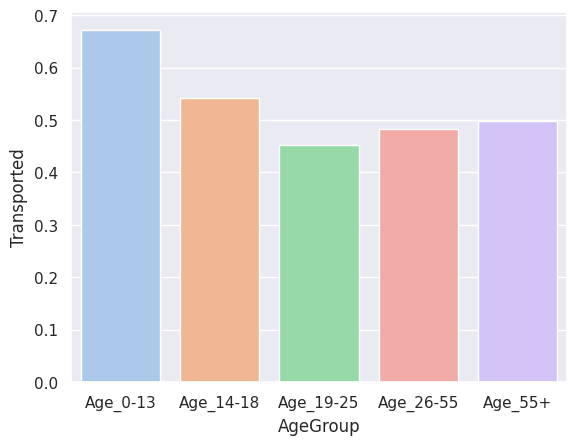

In [13]:
def age_group(data):
    age_group = []
    for age in data["Age"]:
        if age <= 13:
            age_group.append('Age_0-13')
        elif age in range(14, 19):
            age_group.append('Age_14-18')
        elif age in range(19, 26) :
            age_group.append('Age_19-25')
        elif age in range(26, 56):
            age_group.append('Age_26-55')
        elif age >= 55:
            age_group.append('Age_55+')
        else:
            age_group.append(np.nan)
    data["AgeGroup"] = age_group

age_group(train)
age_group(test)

sns.barplot(data=train, x='AgeGroup', y='Transported', order = ['Age_0-13', 'Age_14-18', 'Age_19-25', 'Age_26-55', 'Age_55+'],  errorbar=None)

## 3.2. Cabin groups

The "Cabin" column contains three components: deck type (desc), cabin number, and cabin side, separated by the '/' symbol. Three new columns (Cabin_deck, Cabin_number, Cabin_side) were created to describe these parameters.

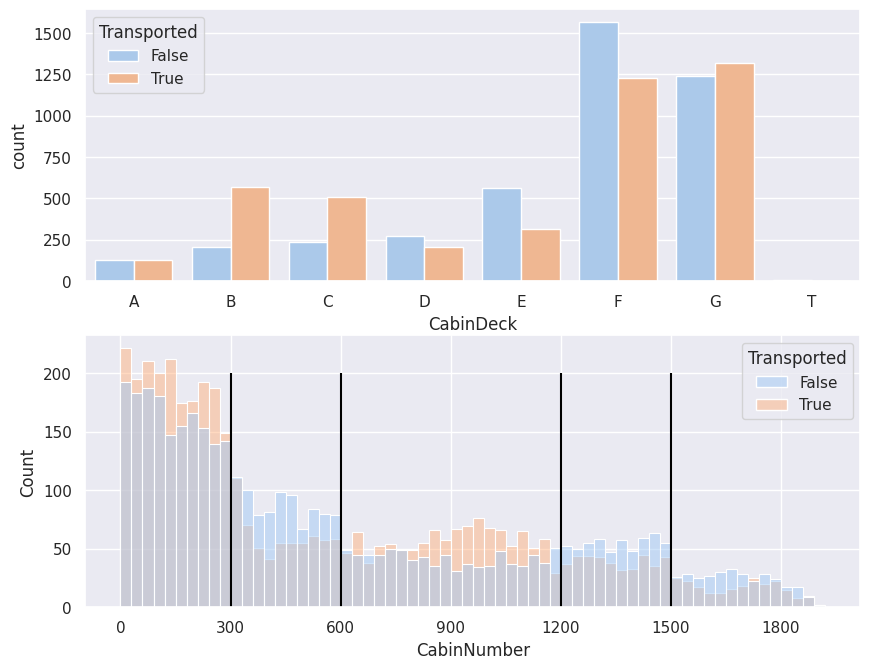

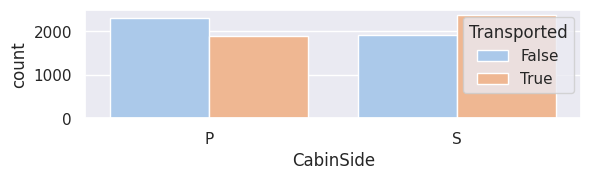

In [14]:
def cabin_split(data):
    data['Cabin'].fillna('np.nan/9999/np.nan', inplace=True)
    
    data['CabinDeck'] = data['Cabin'].apply(lambda x: x.split('/')[0])
    data['CabinNumber'] = data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    data['CabinSide'] = data['Cabin'].apply(lambda x: x.split('/')[2])
    
    data['CabinDeck']=data['CabinDeck'].replace('np.nan', np.nan)
    data['CabinNumber'] = data['CabinNumber'].replace(9999, np.nan)
    data['CabinSide']=data['CabinSide'].replace('np.nan', np.nan)

cabin_split(train)
cabin_split(test)

fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='CabinDeck', hue='Transported', order=['A','B','C','D','E','F','G','T'])

plt.subplot(3,1,2)
sns.histplot(data=train, x='CabinNumber', hue='Transported', binwidth=30)
plt.xticks(list(range(0,1900,300)))
ymax = 200
plt.vlines(300,ymin=0,ymax=ymax,color="black")
plt.vlines(600,ymin=0,ymax=ymax,color="black")
plt.vlines(1200,ymin=0,ymax=ymax,color="black")
plt.vlines(1500,ymin=0,ymax=ymax,color="black")
plt.show()

plt.subplot(3,1,3)
sns.countplot(data=train, x='CabinSide',hue='Transported')
fig.tight_layout()

### Notes
* Most of the people are from F and G decks.
* Passengers from Cabin Deck B and C are **highly** transported.
* Starboard passengers had **highier** likelihood of being transported then port passengers.

In [15]:
def cabin_regions(df):
    df["CabinRegion1"] = (df["CabinNumber"]<300)
    df["CabinRegion2"] = (df["CabinNumber"]>=300) & (df["CabinNumber"]<600)
    df["CabinRegion3"] = (df["CabinNumber"]>=600) & (df["CabinNumber"]<900)
    df["CabinRegion4"] = (df["CabinNumber"]>=900) & (df["CabinNumber"]<1200)
    df["CabinRegion5"] = (df["CabinNumber"]>=1200) & (df["CabinNumber"]<1500)
    df["CabinRegion6"] = (df["CabinNumber"]>=1500)

cabin_regions(train)
train.drop(columns=["CabinNumber"], inplace=True)

cabin_regions(test)
test.drop(columns=["CabinNumber"], inplace=True)


## 3.3 Expenditude group

Creating a column with the total amount of ea expenses additional amenities.

(0.0, 10000.0)

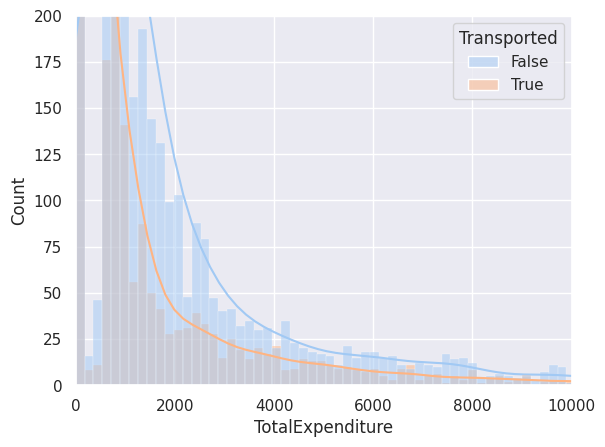

In [16]:
exp_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

def exp_group(df):
    df['TotalExpenditure'] = df[exp_cols].sum(axis=1)
    
exp_group(train)
exp_group(test)

sns.histplot(x="TotalExpenditure", hue="Transported", data=train, kde=True, bins=200)
plt.ylim(0,200)
plt.xlim(0,10000)

In [17]:
print('Mean: ',round(train['TotalExpenditure'].mean()))
print('Median: ', train['TotalExpenditure'].median())

Mean:  1441
Median:  716.0


### Notes
Using above measure of central tendency values we can split Total Expenditure Features into different expense categories:
1.  If Total Expenditure is equal to 0 then No Expense category.
2. If Total Expenditure is between 1-716 then Low Expense category.
3. If Total Expenditure is between 717-1441 then Medium Expense category.
4. If Total Expenditure is greater thean 1441 then High Expense category.

<Axes: xlabel='ExpenditureCategory', ylabel='count'>

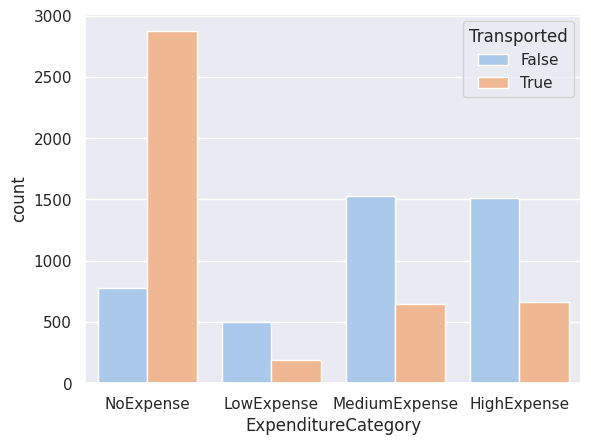

In [18]:
def expenditure_category(data):
    expense_category = []
    for i in data["TotalExpenditure"]:
        if i==0:
            expense_category.append("NoExpense")
        elif i in range(0, 717):
            expense_category.append("LowExpense")
        elif i in range(717, 1442):
            expense_category.append("MediumExpense")
        elif i>1441:
            expense_category.append("HighExpense")
    
    data["ExpenditureCategory"] = expense_category
    
expenditure_category(train)
expenditure_category(test)

sns.countplot(x='ExpenditureCategory', hue="Transported", data=train, order=['NoExpense', 'LowExpense', 'MediumExpense', 'HighExpense'])

## 3.4. Passanger group

In [19]:
train["PassengerId"].head().to_frame()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


We can divide the passengers according to the size of the groups in which they were traveling.

<Axes: xlabel='GroupSize', ylabel='count'>

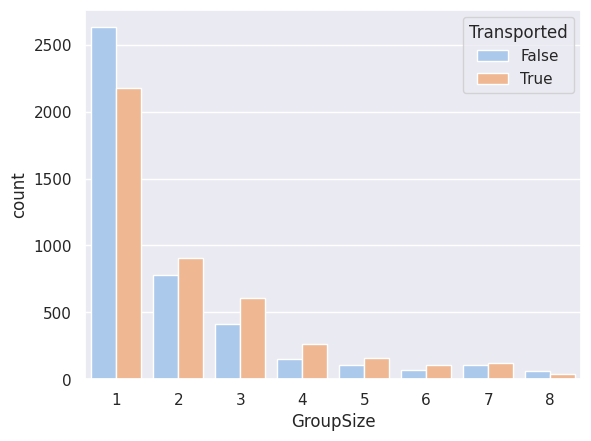

In [20]:
def passengerid_group(data):
    data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    data['GroupSize']= data['Group'].map(lambda x: data['Group'].value_counts()[x])
    
passengerid_group(train)
passengerid_group(test)

sns.countplot(data=train, x='GroupSize', hue='Transported')

We can separately see if a person traveled alone or in a group.

<Axes: xlabel='Solo', ylabel='count'>

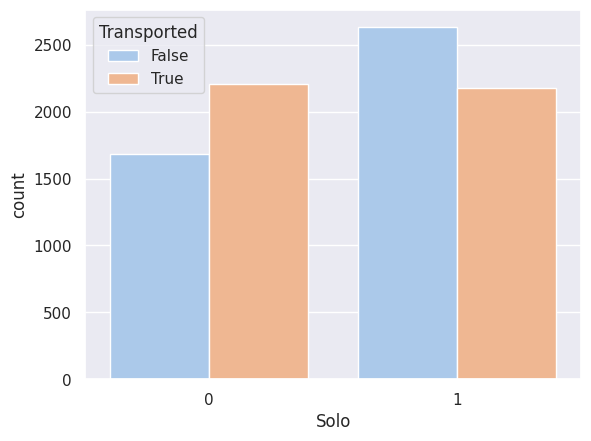

In [21]:
train['Solo']=(train['GroupSize']==1).astype(int)
test['Solo']=(test['GroupSize']==1).astype(int)

sns.countplot(data=train, x='Solo', hue='Transported')

# 4. Missing values

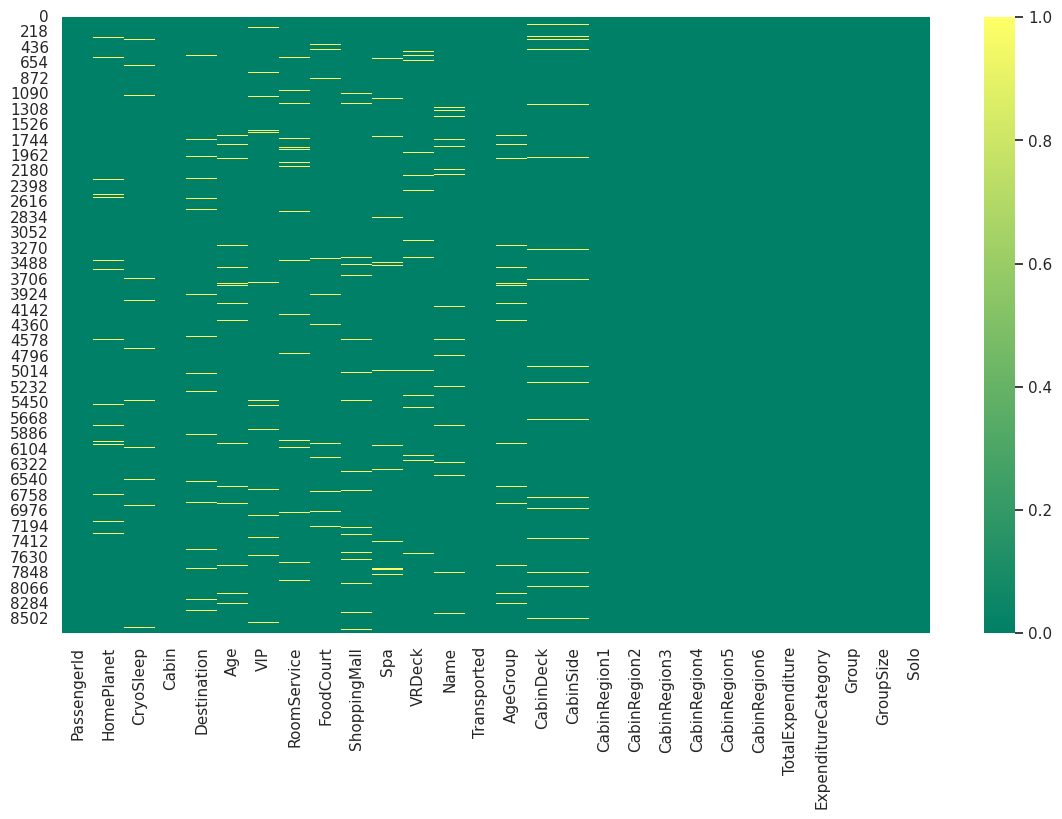

In [22]:
plt.figure(figsize=(14,8))
sns.heatmap(train.isnull(),cmap="summer")
plt.show()


We fill in the numerical gaps according to the rule of the median of the number.
Fill in the remaining gaps with the most common number.

In [23]:
cat_cols = train.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = train.select_dtypes(include=["int","float"]).columns.tolist()

def missing(data):
    data[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(data[cat_cols])
    data[num_cols] = SimpleImputer(strategy="median").fit_transform(data[num_cols])
    
missing(train)
missing(test)

print("Missing numbers in train =",train.isnull().sum().sum())
print("Missing numbers in test =",test.isnull().sum().sum())

Missing numbers in train = 0
Missing numbers in test = 0


In [24]:
pass_df = test[["PassengerId"]] ###Extracting passengerId from test data because qe need this for submitting our predictions on kaggle.

Deleting unnecessary columns

In [25]:
cols = ["PassengerId","Cabin" ,"Name", 'Group']
train.drop(columns=cols, inplace=True)
test.drop(columns=cols, inplace=True)

In [26]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
TotalExpenditure,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0
GroupSize,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Solo,8693.0,0.552744,0.497239,0.0,0.0,1.0,1.0,1.0


Logarithm the values for faster calculation

In [27]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for value in cols:
    train[value] = np.log(1+train[value])
    test[value]=np.log(1+test[value])
    

Overfilling the values in the columns

In [28]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Solo","CabinDeck","CabinSide","CabinRegion1","CabinRegion2",
                    "CabinRegion3","CabinRegion4","CabinRegion5","CabinRegion6","AgeGroup",
                    "ExpenditureCategory"]
enc = LabelEncoder()

train[ordinal_cat_cols] = train[ordinal_cat_cols].apply(enc.fit_transform)
test[ordinal_cat_cols] = test[ordinal_cat_cols].apply(enc.fit_transform)

train = pd.get_dummies(train, columns=nominal_cat_cols)
test = pd.get_dummies(test, columns=nominal_cat_cols)

In [29]:
cols = ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']

train[cols] = train[cols].astype(int)
test[cols] = test[cols].astype(int)

In [30]:
train["Transported"].replace({False:0,True:1},inplace=True)

In [31]:
train.head(10)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup,CabinDeck,CabinSide,CabinRegion1,CabinRegion2,CabinRegion3,CabinRegion4,CabinRegion5,CabinRegion6,TotalExpenditure,ExpenditureCategory,GroupSize,Solo,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,3,1,0,1,0,0,0,0,0,0.0,3,1.0,1,0,1,0,0,0,1
1,0,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,1,2,5,1,1,0,0,0,0,0,736.0,2,1.0,1,1,0,0,0,0,1
2,0,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,0,4,0,1,1,0,0,0,0,0,10383.0,0,2.0,0,0,1,0,0,0,1
3,0,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,0,3,0,1,1,0,0,0,0,0,5176.0,0,2.0,0,0,1,0,0,0,1
4,0,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,1,1,5,1,1,0,0,0,0,0,1091.0,2,1.0,1,1,0,0,0,0,1
5,0,44.0,0,0.000000,6.182085,0.000000,5.676754,0.000000,1,3,5,0,1,0,0,0,0,0,774.0,2,1.0,1,1,0,0,0,1,0
6,0,26.0,0,3.761200,7.339538,1.386294,0.000000,0.000000,1,3,5,1,1,0,0,0,0,0,1584.0,0,2.0,0,1,0,0,0,0,1
7,1,28.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,3,6,1,1,0,0,0,0,0,0.0,3,2.0,0,1,0,0,0,0,1
8,0,35.0,0,0.000000,6.666957,2.890372,5.379897,0.000000,1,3,5,1,1,0,0,0,0,0,1018.0,2,1.0,1,1,0,0,0,0,1
9,1,14.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,0,1,0,0,0,0,0,0.0,3,3.0,0,0,1,0,1,0,0


In [32]:
test.head(10)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,AgeGroup,CabinDeck,CabinSide,CabinRegion1,CabinRegion2,CabinRegion3,CabinRegion4,CabinRegion5,CabinRegion6,TotalExpenditure,ExpenditureCategory,GroupSize,Solo,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,1,27.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3,6,1,1,0,0,0,0,0,0.0,3,1.0,1,1,0,0,0,0,1
1,0,19.0,0,0.000000,2.302585,0.000000,7.945910,0.000000,2,5,1,1,0,0,0,0,0,2832.0,0,1.0,1,1,0,0,0,0,1
2,1,31.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3,2,1,1,0,0,0,0,0,0.0,3,1.0,1,0,1,0,1,0,0
3,0,38.0,0,0.000000,8.802823,0.000000,5.204007,6.373320,3,2,1,1,0,0,0,0,0,7418.0,0,1.0,1,0,1,0,0,0,1
4,0,20.0,0,2.397895,0.000000,6.455199,0.000000,0.000000,2,5,1,1,0,0,0,0,0,645.0,1,1.0,1,1,0,0,0,0,1
5,0,31.0,0,0.000000,7.387709,5.575949,4.736198,4.110874,3,5,0,1,0,0,0,0,0,2051.0,0,1.0,1,1,0,0,0,0,1
6,1,21.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2,1,0,1,0,0,0,0,0,0.0,3,1.0,1,0,1,0,1,0,0
7,1,20.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2,3,1,1,0,0,0,0,0,0.0,3,2.0,0,0,1,0,0,0,1
8,1,23.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2,3,1,1,0,0,0,0,0,0.0,3,2.0,0,0,1,0,1,0,0
9,0,24.0,0,0.000000,6.461468,0.000000,0.000000,0.000000,2,5,1,1,0,0,0,0,0,639.0,1,1.0,1,1,0,0,1,0,0


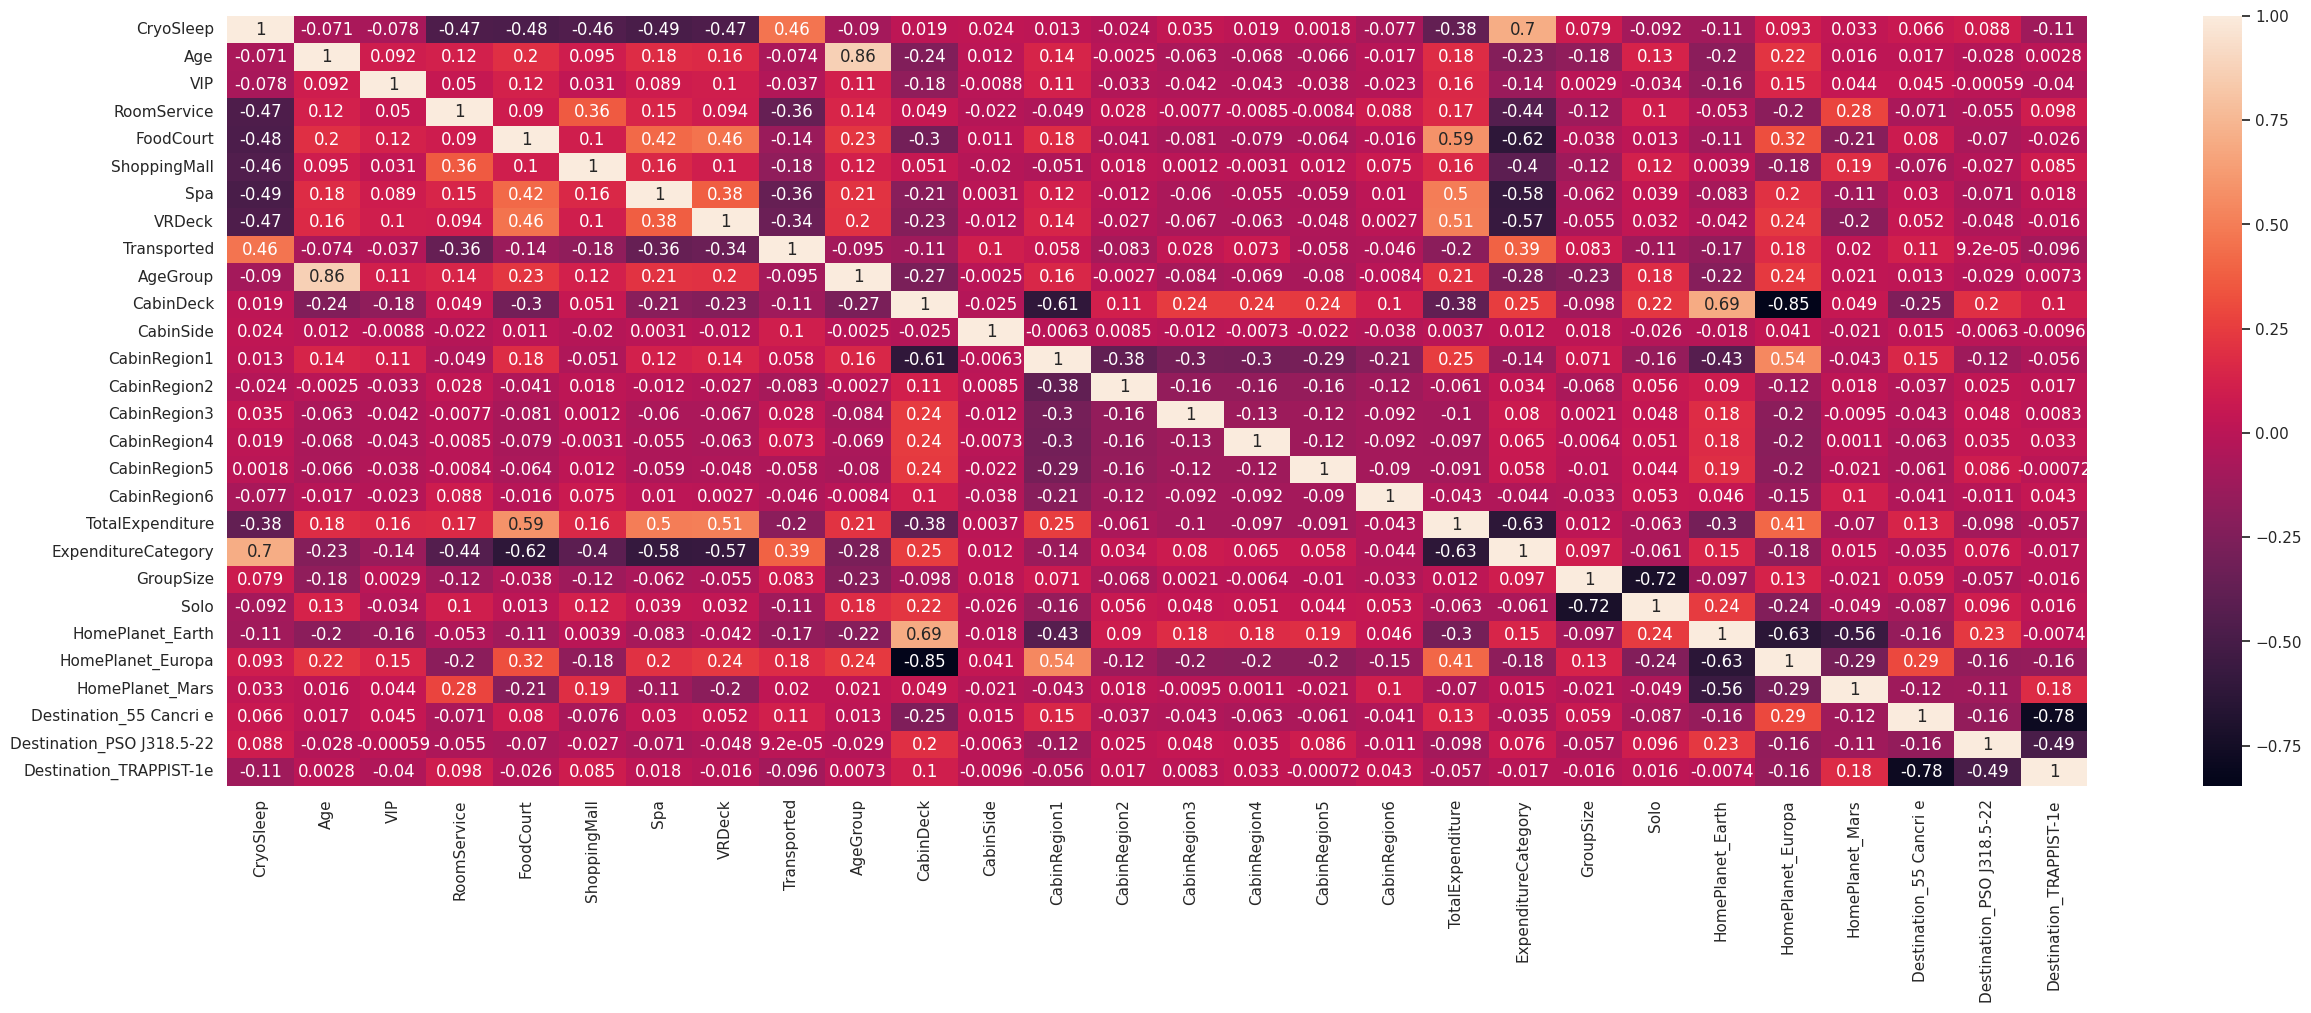

In [33]:
plt.figure(figsize=(30,10))
sns.heatmap(train.corr(), annot=True);

# 5. Model Selecting

### Hold-out method

In [34]:
X = train.drop('Transported', axis=1)
y = train[['Transported']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [35]:
training_score = []
testing_score = []

In [36]:
def model_prediction(model, title):
    model.fit(x_train, y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    a = accuracy_score(y_train,x_train_pred)
    b = accuracy_score(y_test,x_test_pred)
    training_score.append(a)
    testing_score.append(b)

    print(f"Accuracy_Score of {title} model on Training Data is:", a)
    print(f"Accuracy_Score of {title} model on Testing Data is:", b)
    print(f"Precision Score of {title} model is:", precision_score(y_test,x_test_pred))
    print(f"Confusion Matrix of {title} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()

## 5.1. Logistic Regression Model

Accuracy_Score of Logistic Regression model on Training Data is: 0.7751188832643043
Accuracy_Score of Logistic Regression model on Testing Data is: 0.7773689052437902
Precision Score of Logistic Regression model is: 0.7630901287553649
Confusion Matrix of Logistic Regression model is:


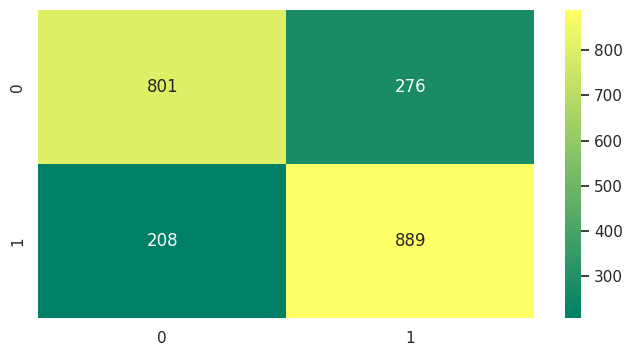

In [37]:
def lr():
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0))
    model_prediction(model, title='Logistic Regression')
    coef = np.abs(model[1].coef_[0])
    return coef

coeff_lr = lr()

## 5.2. Random Forest Classifier Model

Accuracy_Score of Random Forest model on Training Data is: 0.985734008283479
Accuracy_Score of Random Forest model on Testing Data is: 0.7999080036798528
Precision Score of Random Forest model is: 0.8164435946462715
Confusion Matrix of Random Forest model is:


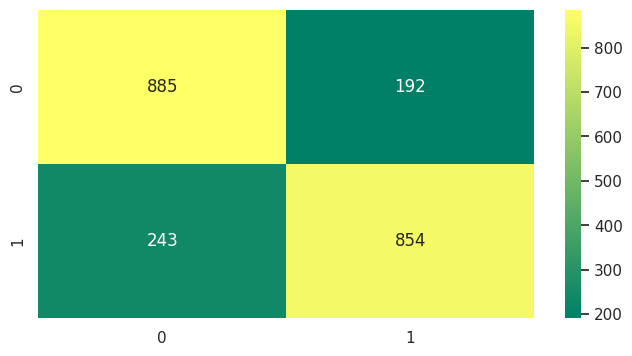

In [38]:
def rf():
    model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 0))
    model_prediction(model, title='Random Forest')
    coef = model[1].feature_importances_
    return coef

coeff_rf = rf()

## 5.3. Cat Boost Classifier Model

Accuracy_Score of Cat Boost model on Training Data is: 0.8766682006442706
Accuracy_Score of Cat Boost model on Testing Data is: 0.8164673413063478
Precision Score of Cat Boost model is: 0.804006968641115
Confusion Matrix of Cat Boost model is:


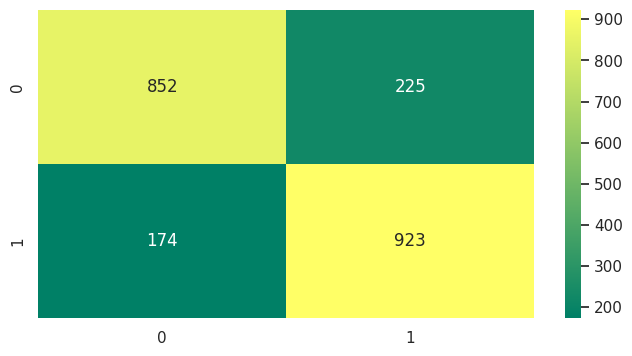

In [39]:
def catboost():
    model = make_pipeline(StandardScaler(), CatBoostClassifier(random_state = 0, verbose=False))
    model_prediction(model, title='Cat Boost')
    coef = model[1].feature_importances_
    return coef

coeff_cat = catboost()

## 5.4. Feature importance

<Axes: ylabel='Feature'>

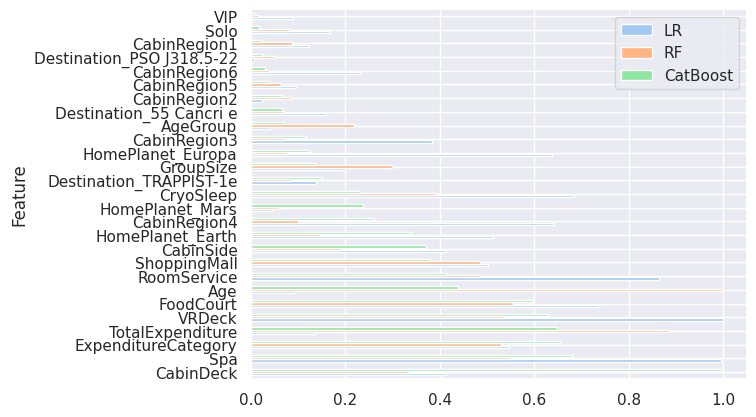

In [40]:
feauture_importances = pd.DataFrame({
    'Feature': X.columns,
    'LR': coeff_lr,
    'RF': coeff_rf,
    'CatBoost': coeff_cat
    })
    
feauture_importances = feauture_importances.sort_values(by = 'CatBoost', ascending=False)
    
sc = MaxAbsScaler()
feauture_importances[['LR']] = sc.fit_transform(feauture_importances[['LR']])
feauture_importances[['RF']] = sc.fit_transform(feauture_importances[['RF']])
feauture_importances[['CatBoost']] = sc.fit_transform(feauture_importances[['CatBoost']])
    
feauture_importances.plot(kind='barh', x='Feature')


<Axes: xlabel='Algorithms'>

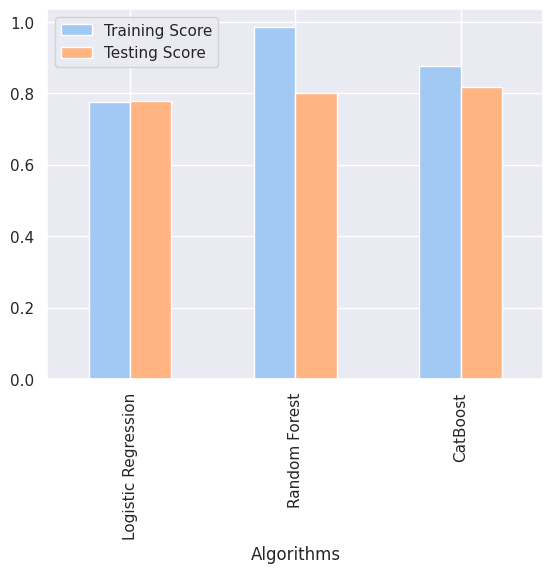

In [41]:
df = pd.DataFrame({'Algorithms': ['Logistic Regression', 'Random Forest', 'CatBoost'],
                   'Training Score': training_score,
                   'Testing Score': testing_score})

df.plot.bar(x='Algorithms', y=['Training Score','Testing Score'])